# Scalability of scmorph
scmorph is designed to process single-cell morphological profiles, which often
involves processing millions of cells. As a result, scalability is important.
This notebook demonstrates the scalability of scmorph vs pycytominer in the task
of median-averaging profiles, which tends to be one of the first steps in
pycytominer. It shows that scmorph has lower memory requirements and scales
better to large datasets than pycytominer.

In [1]:
import timeit
from memory_profiler import memory_usage
import pandas as pd
import scanpy as sc
import scmorph as sm
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
import pycytominer as pc

In [2]:
adata = sm.datasets.rohban2017()

In [3]:
def sample(adata, N=1000):
    return sc.pp.subsample(adata, n_obs=N, copy=True)


def prep_pycytominer(adata):
    adata.obs.columns = "Metadata_" + adata.obs.columns
    df = pd.concat([adata.obs, adata.to_df()], axis=1)
    return df

In [ ]:
N = np.arange(100000, 1e6 + 1, 1e5).astype(int)

In [48]:
adata.shape

(1272644, 1687)

In [28]:
adata_samples = {}
df_samples = {}

for n in N:
    print(n)
    adata_sampled = sample(adata, N=n)
    adata_samples[n] = adata_sampled
    df = prep_pycytominer(adata_sampled.copy())
    df_samples[n] = df

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [29]:
def benchmark_pycytominer_agg(n):
    df = df_samples[n]
    return pc.aggregate(
        df,
        [
            "Metadata_Image_Metadata_Plate",
            "Metadata_Image_Metadata_Well",
            "Metadata_Image_Metadata_Site",
        ],
        operation="median",
    )


def benchmark_scmorph_agg(n):
    adata = adata_samples[n]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return sm.pp.aggregate(
            adata,
            group_keys=["Image_Metadata_Plate", "Image_Metadata_Well", "Image_Metadata_Well"],
            method="median",
            progress=False,
        )

In [25]:
def bench(fun, n):
    if fun == "pycytominer":
        fun = benchmark_pycytominer_agg
    else:
        fun = benchmark_scmorph_agg

    baseline_mem_usage = memory_usage(max_usage=True) * 1.048576  # Convert to MB
    start_t = timeit.default_timer()

    mem_usage = memory_usage((fun, (n,)), max_usage=True) * 1.048576
    elapsed_time = timeit.default_timer() - start_t
    mem_usage -= baseline_mem_usage
    return {"memory_usage": mem_usage, "time_taken": elapsed_time}

In [ ]:
results = {"scmorph": [], "pycytominer": []}
for n in N:
    print(n)
    results["scmorph"].append(bench("scmorph", n))
    results["pycytominer"].append(bench("pycytominer", n))

results_df = pd.DataFrame(
    {
        "N": N,
        "scmorph_memory_usage": [r["memory_usage"] for r in results["scmorph"]],
        "scmorph_time_taken": [r["time_taken"] for r in results["scmorph"]],
        "pycytominer_memory_usage": [r["memory_usage"] for r in results["pycytominer"]],
        "pycytominer_time_taken": [r["time_taken"] for r in results["pycytominer"]],
    }
)
results_df.set_index("N", inplace=True)

100000


200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [34]:
results_df

,scmorph_memory_usage,scmorph_time_taken,pycytominer_memory_usage,pycytominer_time_taken
N,,,,
100000,0.000000,9.290187,2926.018560,3.430380
200000,2.990080,11.262862,5629.771776,7.107579
300000,14.155776,13.203336,8329.809920,10.238860
400000,23.068672,15.140892,11029.405696,13.194921
500000,31.981568,17.068018,13728.731136,16.079890
600000,38.273024,18.689094,16427.687936,18.896825
700000,44.040192,20.889677,19126.951936,21.702588
800000,55.050240,22.885318,21826.162688,24.681145
900000,62.390272,24.864884,24525.389824,27.558561


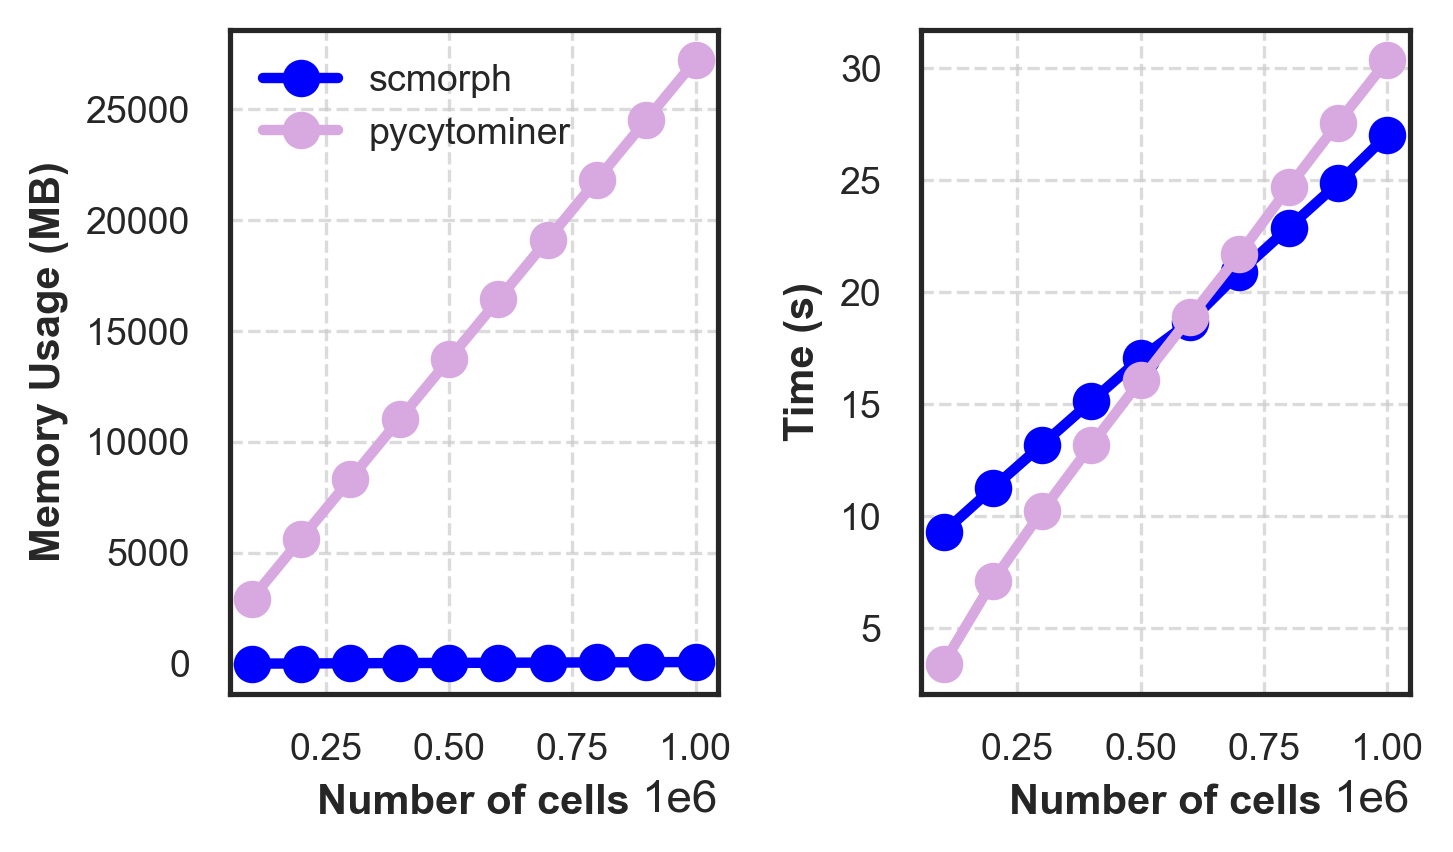

In [56]:
sns.set_theme(style="white")

fig, (ax) = plt.subplots(1, 2, figsize=(5, 3), dpi=300)

ax[0].plot(
    results_df.index,
    results_df["scmorph_memory_usage"],
    color="blue",
    marker="o",
    markersize=8,
    linewidth=2.5,
    label="scmorph",
)
ax[0].plot(
    results_df.index,
    results_df["pycytominer_memory_usage"],
    color="#d8a9e1",
    marker="o",
    markersize=8,
    linewidth=2.5,
    label="pycytominer",
)

ax[1].plot(
    results_df.index,
    results_df["scmorph_time_taken"],
    color="blue",
    marker="o",
    markersize=8,
    linewidth=2.5,
    label="scmorph",
)

ax[1].plot(
    results_df.index,
    results_df["pycytominer_time_taken"],
    color="#d8a9e1",
    marker="o",
    markersize=8,
    linewidth=2.5,
    label="pycytominer",
)

ax[0].set_xlabel("Number of cells", fontsize=10, fontweight="bold")
ax[0].set_ylabel("Memory Usage (MB)", fontsize=10, fontweight="bold")
ax[0].tick_params(axis="both", labelsize=9)
ax[0].legend(loc="upper left", fontsize=9, frameon=False)

ax[1].set_xlabel("Number of cells", fontsize=10, fontweight="bold")
ax[1].set_ylabel("Time (s)", fontsize=10, fontweight="bold")
ax[1].tick_params(axis="both", labelsize=9)

ax[0].grid(True, which="major", axis="both", linestyle="--", linewidth=0.8, alpha=0.7)
ax[1].grid(True, which="major", axis="both", linestyle="--", linewidth=0.8, alpha=0.7)

plt.tight_layout()
plt.show()